# Keras implementation of <i> Character Aware Neural Models </i> by Yoon Kim et al.


## Introduction/Disclaimer

<p>
This notebook tries to understand the structure and implement the character RNN given in [Kim, 2016](https://arxiv.org/abs/1508.06615). While there is [code](https://github.com/yoonkim/lstm-char-cnn) available online by the authors, that is available in Torch (and there are several PyTorch implementations available). The current notebook tries to aid people in recreating such models in Keras, rather than having a model that works out-of-the-box. I am also currently not very confident about my approach myself, so please if you have any comments, open an issue ticket. </p>


## Description

The model is a character-input sequential model for next-word prediction. It accepts as input a word as a series of characters (represented as integers), and spits a probability distribution of the next word. It differs from other character RNN models in that it considers the whole word at each timestep, instead of a single character, and from word RNN models in that it accepts characters-as-integers and not words-as-integers. Below we show how we <b> pre-process </b> a corpus `.txt` file to feed into the model, how we <b> build </b> the model into keras and finally how we <b> train & evaluate </b> it.

## Requirements
Python packages `keras`, `numpy` and `tensorflow` (might also work with Theano but I haven't tried it). Also a GPU with CUDA is *highly* recommended.

### Preprocessing

Assume we have a corpus `train.txt` for training, `valid.txt` for validation and `test.txt` for testing. We split each corpus into words.

<b> Note: </b> The corpus we use here is the same as the corpus used by Kim, Y. et al. in their repo. The prepared corpus have some words that appear only once (e.g. some very rare proper names) and in that case they have been erplaced with the token `<unk>`.

Training has words $W_{tr}=[w_1,w_2,...,w_T]$. Validation has words $W_{vd}$ and testing $W_{ts}$. 



In [1]:
with open('train.txt') as f:
    W_tr = f.read().split()
    
with open('valid.txt') as f:
    W_vd = f.read().split()
    
with open('test.txt') as f:
    W_ts = f.read().split()

For each word $w_{1...T}$ in training:
1. Convert $w_t$ into a series of characters: $w_t = [c_1, c_2, ..., c_N]$
2. For each word $w_t$ and character $c_n$, assign them an integer $t$ and $n$ respectively in the
Look Up Tables (LUTs) `word_idx` and `char_idx` accordingly. Also create the inverse mapping LUTs `idx_word` and `idx_char` that map from integers to words (and characters).
3. Replace $c_n$ and $w_t$ with $n$ and $t$ respectively.

<b> Note: </b> We also include characters `begin` and `end` (they are not python characters but for our purposes we can use them as such) to signify the beginning and ending of each word. 

<b> Note 2: </b> We assign the integer `0` to character `''` (no character) and word `''` (no word). Since we use keras, we need to use padding to our models and this is done by filling with `0`. It is important that `0` does not correspond to a valid character or word. 

In [2]:
# First gather all the words and characters. 
words_training = list(set(W_tr))
chars_training = []
for word in words_training:
    for char in word:
        if char not in chars_training:
            chars_training.append(char)
            
chars_training.append('begin')
chars_training.append('end')

# Create the look up table as a python dictionary
word_idx = dict((words_training[n], n+1) for n in range(len(words_training)))
word_idx[''] = 0

char_idx = dict((chars_training[n], n+1) for n in range(len(chars_training)))
char_idx[''] = 0

# Also create the inverse as a python dictionary
idx_word = dict((word_idx[w], w) for w in word_idx)
idx_char = dict((char_idx[c], c) for c in char_idx)

In order to train the model later, we need to turn our corpora into pairs of (Input, Output). We do this with the function below (accepts a corpus file as a list of words as input). We make this a function since we are going to be using it several times below.

<b> Note </b> Since `<unk>` words appear only once, we omit them from training.

In [3]:
def prepare_inputs_outputs(words):
    # Remember that the output is a single word.
    output_words = [] 
    
    # The input is a word split into characters. 
    input_words = []
    
    for n in range(len(words) - 1):
        # <unk> are words that appear only once, so omit them.
        #if words[n] != '<unk>' and words[n+1] != '<unk>':
        input_words.append(words[n])
        output_words.append(words[n+1])
            
    # The input words split into sequence of characters
    input_seqs = []
    for n in range(len(input_words)):
        input_seqs.append(
            # Remember that each word starts with the character begin and ends with end.
            ['begin'] + [c for c in input_words[n]] + ['end']
        )
        
    # Final input, output
    inputs = input_seqs
    outputs = output_words
    
    return inputs, outputs

    
inputs_tr, outputs_tr = prepare_inputs_outputs(W_tr)
inputs_vd, outputs_vd = prepare_inputs_outputs(W_vd)
inputs_ts, outputs_ts = prepare_inputs_outputs(W_ts)


print("First 10 (input, output) pairs in training corpus: ")
for n in range(10):

    print('[Sample {}]'.format(n), 'Input:',inputs_tr[n], 'Output:',outputs_tr[n])

First 10 (input, output) pairs in training corpus: 
[Sample 0] Input: ['begin', 'a', 'e', 'r', 'end'] Output: banknote
[Sample 1] Input: ['begin', 'b', 'a', 'n', 'k', 'n', 'o', 't', 'e', 'end'] Output: berlitz
[Sample 2] Input: ['begin', 'b', 'e', 'r', 'l', 'i', 't', 'z', 'end'] Output: calloway
[Sample 3] Input: ['begin', 'c', 'a', 'l', 'l', 'o', 'w', 'a', 'y', 'end'] Output: centrust
[Sample 4] Input: ['begin', 'c', 'e', 'n', 't', 'r', 'u', 's', 't', 'end'] Output: cluett
[Sample 5] Input: ['begin', 'c', 'l', 'u', 'e', 't', 't', 'end'] Output: fromstein
[Sample 6] Input: ['begin', 'f', 'r', 'o', 'm', 's', 't', 'e', 'i', 'n', 'end'] Output: gitano
[Sample 7] Input: ['begin', 'g', 'i', 't', 'a', 'n', 'o', 'end'] Output: guterman
[Sample 8] Input: ['begin', 'g', 'u', 't', 'e', 'r', 'm', 'a', 'n', 'end'] Output: hydro-quebec
[Sample 9] Input: ['begin', 'h', 'y', 'd', 'r', 'o', '-', 'q', 'u', 'e', 'b', 'e', 'c', 'end'] Output: ipo


In the paper we see that training is done in groups of `seq_len=30` timesteps for non-arabic corpora, so we group the inputs and outputs accordingly:




In [4]:
seq_len = 35

inputs_tr_seq = []
outputs_tr_seq = []

for n in range(0, len(inputs_tr)-seq_len, seq_len):
    # rearrange input into groups of 25 samples
    # let's say input has words-as-character-sequences W = [W_1, W_2, ..., W_N]
    input_seq = inputs_tr[n:n+seq_len]
    
    # Then since the goal is to predict the next word, the output 
    # has the sequence of words-as-words W' = [W_2, W_3, ..., W_N+1]
    output_seq = outputs_tr[n:n+seq_len]
    
    inputs_tr_seq.append(input_seq)
    outputs_tr_seq.append(output_seq)
    
# Before each (charachters, word) pair was a single sample. Now a single sample
# is ([(characters, ..., characters, characters), (word, ..., word, word)]).

# Example.
for n in range(2):
    print('[Sample {}]'.format(n))
    print('Input:\n',inputs_tr_seq[n])
    print('Output:\n',outputs_tr_seq[n])   
    print('')

[Sample 0]
Input:
 [['begin', 'a', 'e', 'r', 'end'], ['begin', 'b', 'a', 'n', 'k', 'n', 'o', 't', 'e', 'end'], ['begin', 'b', 'e', 'r', 'l', 'i', 't', 'z', 'end'], ['begin', 'c', 'a', 'l', 'l', 'o', 'w', 'a', 'y', 'end'], ['begin', 'c', 'e', 'n', 't', 'r', 'u', 's', 't', 'end'], ['begin', 'c', 'l', 'u', 'e', 't', 't', 'end'], ['begin', 'f', 'r', 'o', 'm', 's', 't', 'e', 'i', 'n', 'end'], ['begin', 'g', 'i', 't', 'a', 'n', 'o', 'end'], ['begin', 'g', 'u', 't', 'e', 'r', 'm', 'a', 'n', 'end'], ['begin', 'h', 'y', 'd', 'r', 'o', '-', 'q', 'u', 'e', 'b', 'e', 'c', 'end'], ['begin', 'i', 'p', 'o', 'end'], ['begin', 'k', 'i', 'a', 'end'], ['begin', 'm', 'e', 'm', 'o', 't', 'e', 'c', 'end'], ['begin', 'm', 'l', 'x', 'end'], ['begin', 'n', 'a', 'h', 'b', 'end'], ['begin', 'p', 'u', 'n', 't', 's', 'end'], ['begin', 'r', 'a', 'k', 'e', 'end'], ['begin', 'r', 'e', 'g', 'a', 't', 't', 'a', 'end'], ['begin', 'r', 'u', 'b', 'e', 'n', 's', 'end'], ['begin', 's', 'i', 'm', 'end'], ['begin', 's', 'n', 

In order to actually use the inputs and outputs with our model, we convert them to integers. This is as straightforward as looking using LUTs defined above (`word_idx` for words, `char_idx` for characters) and replacing each word and character with its corresponding integer. We can try that:

In [5]:
import numpy as np

# Since in keras pretty much everything 
# has to be of fixed size, figure out the
# maximum number of characters there is in a 
# word, and add 2 (for the characters begin and end)
max_word_len = max([len(w) for w in words_training]) + 2

# Create the output for the inputs (will probably give a MemoryError. If it doesn't 
# still use the method below since people are going to start whining of you taking 
# too much memory (assuming it is a memory machine)).
y = np.zeros(
    (len(outputs_tr_seq), # Same number of samples as input
     seq_len,             # Same number of timesteps
     len(words_training)  # Categorical distribution
    )
)

MemoryError: 

We get a `MemoryError`. That is because the output has a total number of elements: `len(outputs_tr_seq)*seq_len*len(words_training)) = 26721*35*9999 = 8015498370` which requires
over `32GB` to store for 4 byte integers! We will consider a different approach by constructing a `generator`. This is a function that yields a single batch of input paired by a single batch of output every time. We will later use that generator with the `fit_generator` method of our model.

<b> Note: </b> Since we are using a generator, we need to specify the number of samples in a batch in advance.

In [6]:
batch_size = 20

def generator(words,                 # The corpora to 
              batch_size=batch_size, # The desired batch size
              seq_len=seq_len,       # The timesteps at each batch
              char_idx=char_idx,     # The character-to-integer LUT
              word_idx=word_idx,     # The word-to-integer LUT
             ):
    
    inputs, outputs = prepare_inputs_outputs(words) # Prepare the inputs and outputs as above
    
    x = np.zeros((batch_size, seq_len, max_word_len))
    y = np.zeros((batch_size, seq_len, len(word_idx)))
    
    I = 0                            # Since the generator never "terminates"
                                     # we traverse through our samples from the
                                     # beginning to the end, back to the 
                                     # beginning, etc...
    while 1:
        # Clear the vectors at each yield.
        x[:,:,:] = 0.0
        y[:,:,:] = 0.0
        
        for sample in range(batch_size):
            for time in range(seq_len):
                if I >= len(inputs):
                    I = 0            # If we are at the last sample and last timestep, 
                                     # move to the beginning.
                        
                for n, char in enumerate(inputs[I]):
                    x[sample, time, n] = char_idx[char]  # Replace with integer
                    
                y[sample, time, word_idx[outputs[I]]] = 1.0
                                                         # Set 1.0 to the position of 
                                                         # the vector given by the integer
                                                         # from the word LUT for the word
                                                         # at outputs[I]
                                
                I += 1 
        yield x, y
                    
# Example: Show the first 10 input/output shapes as vectors
gen = generator(W_tr)

I = 0
for x, y in gen:
    if I >= 10:
        break
    print("[Batch: {}]".format(I),"Input: ",x.shape,"Output:",y.shape)
    I += 1

[Batch: 0] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 1] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 2] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 3] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 4] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 5] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 6] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 7] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 8] Input:  (20, 35, 21) Output: (20, 35, 10000)
[Batch: 9] Input:  (20, 35, 21) Output: (20, 35, 10000)


## Implementation 

The model is given in Fig ? in the paper and looks like the figure below: 

![model figure](model.png). 

Note that this is for one time step. At time $t$ the input is a word-as-string-of-characters $w_t = [c_1 c_2 \dots c_N]$ (where $c_n$ is an integer), and the output is the probability distribution over all words $W_{t+1}$. 

Note the LSTM stage has an output to itself. Its input at time $t$ isn't output of the Highway Network at time $t$ but the output of the LSTM itself at time $t-1$. 

In order to train it, we will "unroll" the LSTM for `seq_len=25` time steps. Since the LSTM at each timestep also depends on the outputs of the highway network at this timestep we also have to distribute the previous stages across time. The final model will then be: 

![model_unrolled](model_unrolled.png)

In the block diagram above, with pink we have the inputs/outputs and with teal the various components of the model. We will go about building each component separately as a keras model and then we will put them together in order to build the composite model.

### Embeddings layer

The embeddings layer is quite simple, it inputs a series of characters as integers $[c_1, c_2, ... c_N]$ and it outputs a matrix $V = [v_1 v_2 \dots v_N]$  where each row $v_i$ (of `embeddings_size = 15` columns) is an embedding of character $c_i$. Let's implement it:



/home/mmxgn/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embeddings (Embedding)       (20, 21, 15)              780       
Total params: 780
Trainable params: 780
Non-trainable params: 0
_________________________________________________________________


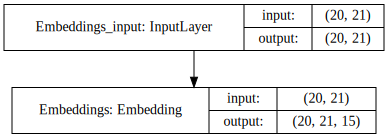

In [7]:
# First import the relevant keras modules
import keras
from keras import layers

# embeddings_size is the dimension of the embeddings vector of each character
embeddings_size = 15

# Because we want to build the composite model step-by-step
# each layer we define is going to be wrapped into a model
Embeddings = keras.Sequential()

Embeddings.add(
    layers.Embedding(
        len(char_idx) + 1,      # Input is the number of possible characters + 1
        embeddings_size,        # Output is the dimension of the embeddings vector
        name = 'Embeddings',
        #embeddings_initializer='random_normal',
        batch_input_shape=(batch_size,max_word_len)
    )
)
Embeddings.name = 'Embeddings'

# Show details to check on input/output dimensions
Embeddings.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(Embeddings, show_shapes=True).create(prog='dot', format='svg'))

In the paper $V$ is a stack of the embeddings as column-vectors instead of row-vectors. The first dimension in `(None, None, 15)` is the batch dimension. The second is the number of characters $N$ in each word. Let's see initially how the embeddings look like (they will change during training).


Text(0,0.5,'character as integer')

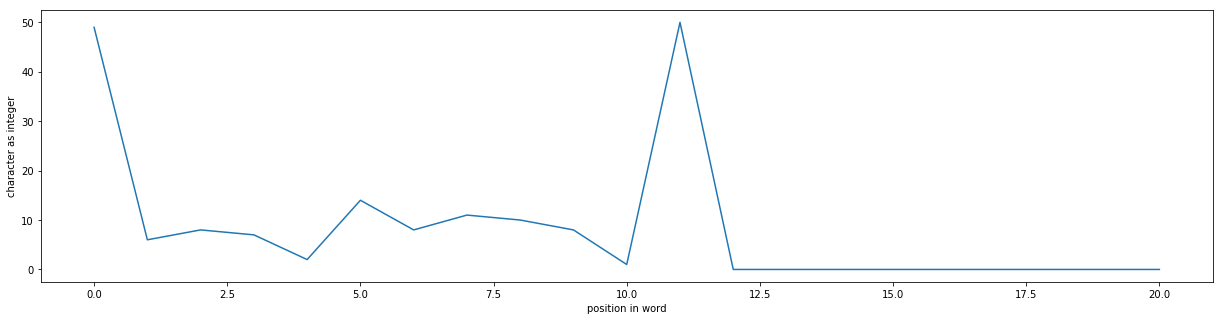

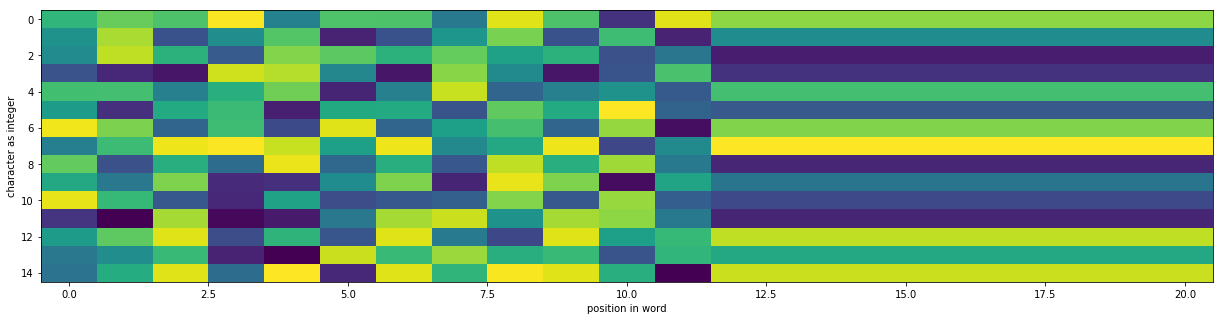

In [8]:
# We generated some x's and y's above, use a slice for visualization purposes
sample_input = x[:, 0, :]
embeddings_output = Embeddings.predict(sample_input)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(21,5))
# Plot first word as integer characters
plt.plot(sample_input[0,:])
plt.xlabel('position in word')
plt.ylabel('character as integer')

plt.figure(figsize=(21,5))
plt.imshow(embeddings_output[0,:,:].T, aspect='auto')
plt.xlabel('position in word')
plt.ylabel('character as integer')

## Convolutional

The convolutional layer takes the embeddings and applies a number of 1D filters of various shapes across the character dimension. For the small model described in the paper, it filters it through the following number of 1D filters of the following sizes:

|`num_filters` | `w` |
|------------|-------|
|25 | 1 |
|50 | 2|
|75 | 3|
|100 | 4|
|125 | 5|
|150 | 6|

 This can be implemented in keras using the functional API and a for loop. Foreach number of filters `num_filters` and width `w`  in the matrix above:

1. Create a `Conv1D` layer of size `num_filters` and shape `w` 
2. Apply max pooling over time using `GlobalMaxPool1D`
3. Append output to a list `L`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputFromEmbeddings (InputLayer (20, 21, 15)         0                                            
__________________________________________________________________________________________________
Conv1D_25_1 (Conv1D)            (20, 21, 25)         400         InputFromEmbeddings[0][0]        
__________________________________________________________________________________________________
Conv1D_50_2 (Conv1D)            (20, 20, 50)         1550        InputFromEmbeddings[0][0]        
__________________________________________________________________________________________________
Conv1D_75_3 (Conv1D)            (20, 19, 75)         3450        InputFromEmbeddings[0][0]        
__________________________________________________________________________________________________
Conv1D_100

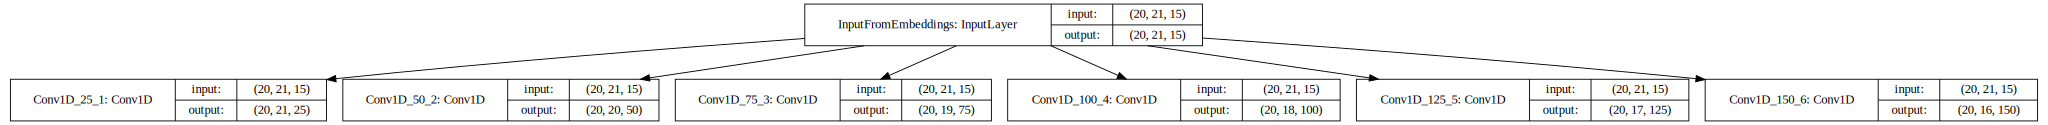

In [9]:
num_filters_per_layer = [25, 50, 75, 100, 125, 150]

filter_widths_per_layer = [1, 2, 3, 4, 5 ,6]

inputs = layers.Input(
    batch_shape=(batch_size, max_word_len, embeddings_size),  # The input to this layer comes from the output
                                                              # of the embeddings layer, therefore must have 
                                                              # the same shape as the embedding's output
    name='InputFromEmbeddings'
)

L = [] # Will keep record of the outputs of maxpooling

for n in range(len(num_filters_per_layer)):
    num_filters = num_filters_per_layer[n]
    w = filter_widths_per_layer[n]
    
    # Create a Conv1D layer
    x = layers.Conv1D(num_filters, 
                      w,
                     activation='tanh',  # Hyperbolic tangent is used as the activation layer
                     name='Conv1D_{}_{}'.format(num_filters, w) # Give the layer a representative name
                     )(inputs)                                  # for debugging purposes.
    
    # Append to outputs that will be concatenated
    L.append(x)

# Again, wrap it into a model.

Convolutional = keras.Model(
    inputs=inputs,
    outputs=L,
    name='Convolutional'
)

Convolutional.summary()
SVG(model_to_dot(Convolutional, show_shapes=True).create(prog='dot', format='svg'))

Let's see how it transforms our input at this stage (remember the output from embeddings in in `embeddings_output` of shape `(30,21,15)`):

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


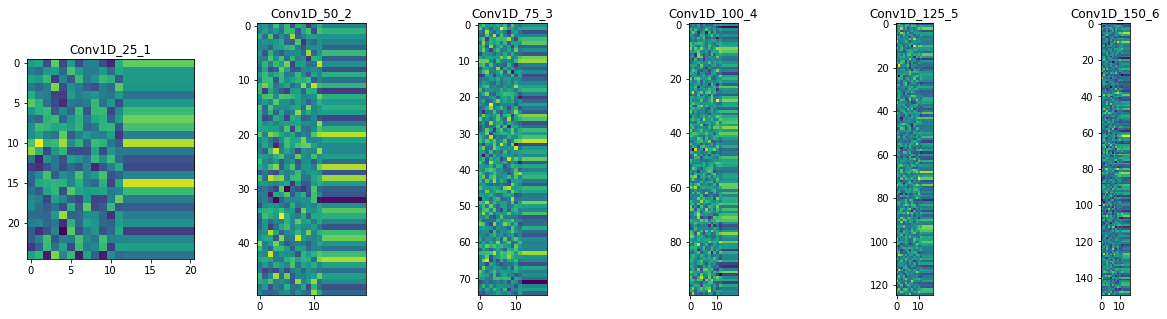

In [10]:
convolutional_output = Convolutional.predict(embeddings_output)
plt.figure(figsize=(21,5))
plt.subplot(1, len(convolutional_output), 1)

for n, outp in enumerate(convolutional_output):
    plt.subplot(1, len(convolutional_output), n+1)
    plt.imshow(outp[0,:,:].T)
    plt.title('Conv1D_{}_{}'.format(num_filters_per_layer[n],filter_widths_per_layer[n]))


## MaxPoolingOverTime

MaxPooling over time is implemented using a `GlobalMaxPool1D` layer on the outputs of the Convolutional layer. Then those outputs are concatenated to provide a fixed representation. 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
FromConvolutional_0 (InputLayer (20, 21, 25)         0                                            
__________________________________________________________________________________________________
FromConvolutional_1 (InputLayer (20, 20, 50)         0                                            
__________________________________________________________________________________________________
FromConvolutional_2 (InputLayer (20, 19, 75)         0                                            
__________________________________________________________________________________________________
FromConvolutional_3 (InputLayer (20, 18, 100)        0                                            
__________________________________________________________________________________________________
FromConvol

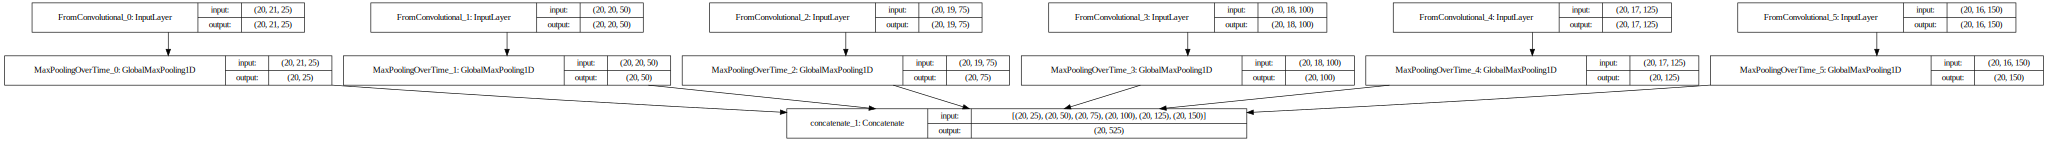

In [11]:
inputs = [] # list that holds the inputs, 
            # must be of similar size as the outputs of the Convolutional block
L = []      # Stores the outputs of the maxpooling in order to concatenate them later
    
for n in range(len(convolutional_output)):
    # This looks complicated but is really an input layer that matches
    # the output of the convolutional layer.
    inputs.append(
        layers.Input(
            batch_shape=(
                20,
                convolutional_output[n].shape[1], 
                convolutional_output[n].shape[2]
            ),
            name = 'FromConvolutional_{}'.format(n)
        
        )
    )
    
    # Max Pooling over time for input n
    x = layers.GlobalMaxPool1D(name='MaxPoolingOverTime_{}'.format(n))(inputs[n])
    
    # Append the output of max pooling to L
    L.append(x)
    
outputs = layers.Concatenate()(L) # Concatenated the outputs in L

# Wrap it into a model 
MaxPoolingOverTime = keras.Model(
    inputs = inputs,
    outputs = outputs,
    name = 'MaxPoolingOverTime'
)

MaxPoolingOverTime.summary()

# Block diagram
SVG(model_to_dot(MaxPoolingOverTime, show_shapes=True).create(prog='dot', format='svg'))

Here is an example of the output at this layer for one word:

Text(0.5,1,'Concatenate')

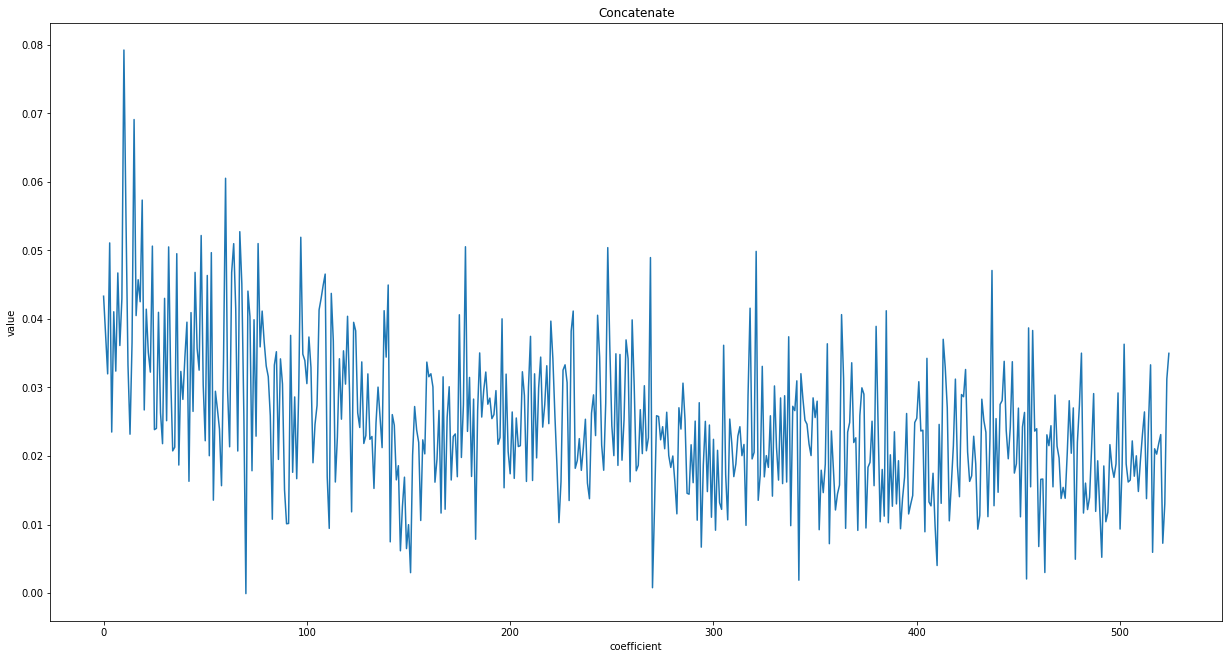

In [12]:
maxpooling_output = MaxPoolingOverTime.predict(convolutional_output)
plt.figure(figsize=(21,11))
plt.plot(maxpooling_output[0,:])
plt.xlabel('coefficient')
plt.ylabel('value')
plt.title('Concatenate')

## Highway network

A Highway network is indicative of its name. It is a network that transforms its input
and also carries part of it intact to the output. It is easily implemented using the functional
API as such (see paper for the equations):

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (20, 525)            0                                            
__________________________________________________________________________________________________
transorm_gate (Dense)           (20, 525)            276150      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (20, 525)            276150      input_1[0][0]                    
__________________________________________________________________________________________________
carry_gate (Lambda)             (20, 525)            0           transorm_gate[0][0]              
__________________________________________________________________________________________________
multiply_1

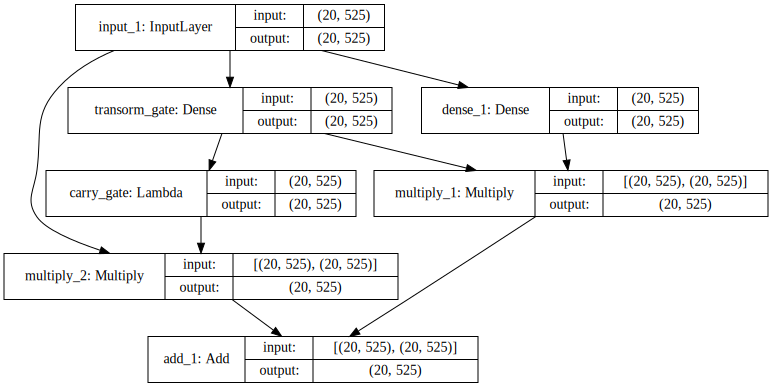

In [13]:
inputs = layers.Input(batch_shape=(
    batch_size, maxpooling_output.shape[1],))  # The input must match the output of 
                                               # the MaxPoolingOverTime layer
    
transform_gate = layers.Dense(maxpooling_output.shape[1],
                             activation='sigmoid',
                             name='transorm_gate')(inputs)

carry_gate = layers.Lambda(lambda x: 1-x,
                           name='carry_gate')(transform_gate)

z = layers.Add()([
    layers.Multiply()([
        transform_gate,
        layers.Dense(maxpooling_output.shape[1],
                    activation='relu')(inputs)
    ]),
    layers.Multiply()([carry_gate, inputs])
])

Highway = keras.Model(
    inputs=inputs, 
    outputs=z,
    name='Highway'
)

Highway.summary()

# Block diagram
SVG(model_to_dot(Highway, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

The necessary output example:

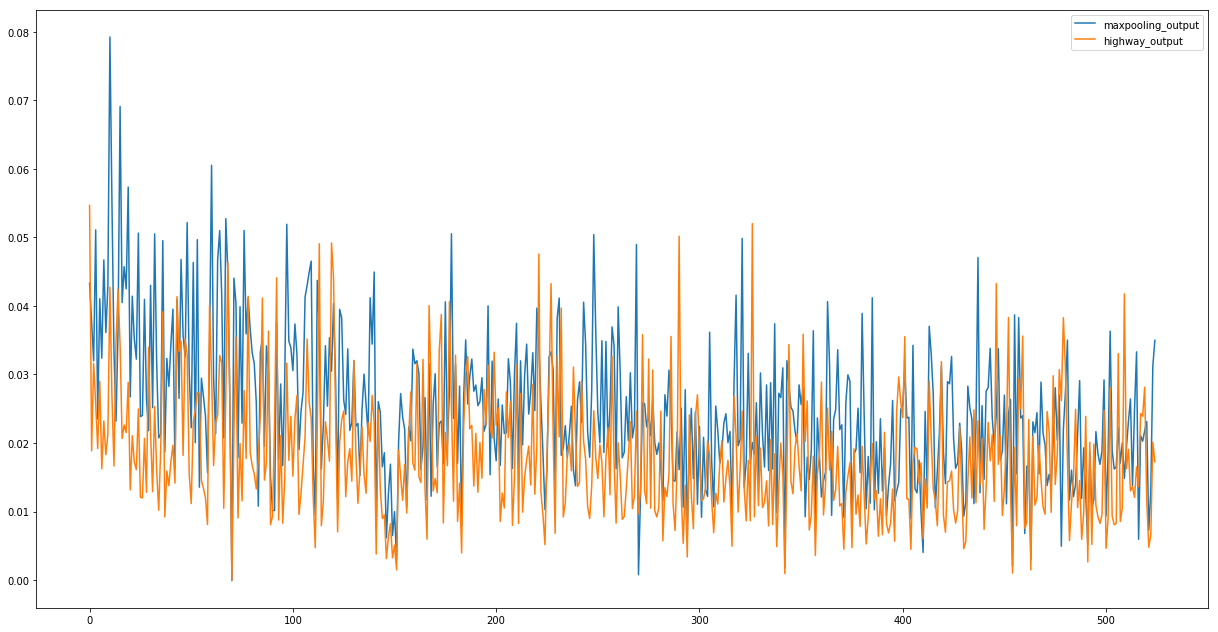

In [14]:
highway_output = Highway.predict(maxpooling_output)
plt.figure(figsize=(21,11))
plt.plot(maxpooling_output[0])
plt.plot(highway_output[0])
plt.legend(['maxpooling_output', 'highway_output'])

## Combining Embedding, Convolutional, MaxPool, and Highway

Before implementing our LSTM layer, we will combine the above layers to a FeatureExtract layer. 
We will then distribute that layer across time for all time instants $t-25+1, \dots t-1, t$ which we will provide to the LSTM layer unrolled for those time instants.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Embeddings_input (InputLayer)   (20, 21)             0                                            
__________________________________________________________________________________________________
Embeddings (Sequential)         (20, 21, 15)         780         Embeddings_input[0][0]           
__________________________________________________________________________________________________
Convolutional (Model)           [(20, 21, 25), (20,  34650       Embeddings[1][0]                 
__________________________________________________________________________________________________
MaxPoolingOverTime (Model)      (20, 525)            0           Convolutional[1][0]              
                                                                 Convolutional[1][1]              
          

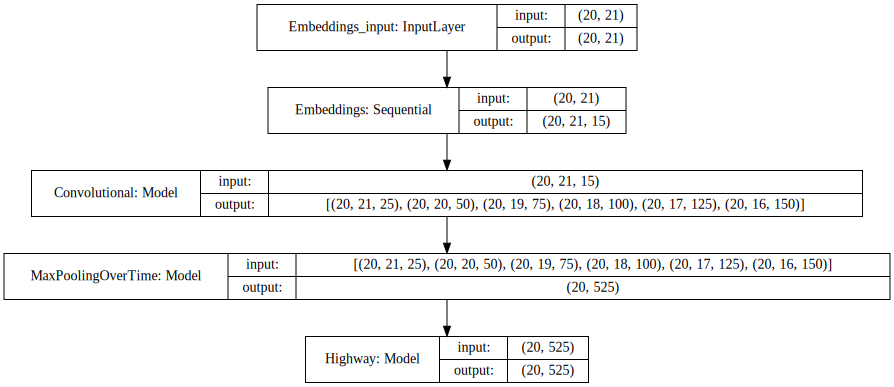

In [15]:
inputs = Embeddings.inputs
x = Embeddings(inputs=inputs)
x = Convolutional(inputs=x)
x = MaxPoolingOverTime(inputs=x)
x = Highway(inputs=x)

FeatureExtract = keras.Model(inputs=inputs, outputs=x)
FeatureExtract.summary()

# Block diagram
SVG(model_to_dot(FeatureExtract, show_shapes=True).create(prog='dot', format='svg'))

`FeatureExtract` does process one word at a time but at training time we process sequences of words of length `seq_len=25`. We are going to assign a `FeatureExtract` at each timestep with the `TimeDistributed` layer:

In [16]:
CharRNN = keras.Sequential()
CharRNN.add(
    layers.TimeDistributed(
        FeatureExtract,
        batch_input_shape=(batch_size,seq_len,max_word_len), # We need to declare shape
        name='SequenceFeatureExtract'
    )
)

CharRNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SequenceFeatureExtract (Time (20, 35, 525)             587730    
Total params: 587,730
Trainable params: 587,730
Non-trainable params: 0
_________________________________________________________________


We finally add 2 LSTM layers with `hidden_units = 300` hidden units and a time distributed `Dense` layer
with `softmax` activation.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SequenceFeatureExtract (Time (20, 35, 525)             587730    
_________________________________________________________________
RNN1 (LSTM)                  (20, 35, 300)             991200    
_________________________________________________________________
dropout_1 (Dropout)          (20, 35, 300)             0         
_________________________________________________________________
RNN2 (LSTM)                  (20, 35, 300)             721200    
_________________________________________________________________
dropout_2 (Dropout)          (20, 35, 300)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (20, 35, 10000)           3010000   
Total params: 5,310,130
Trainable params: 5,310,130
Non-trainable params: 0
_________________________________________________________________


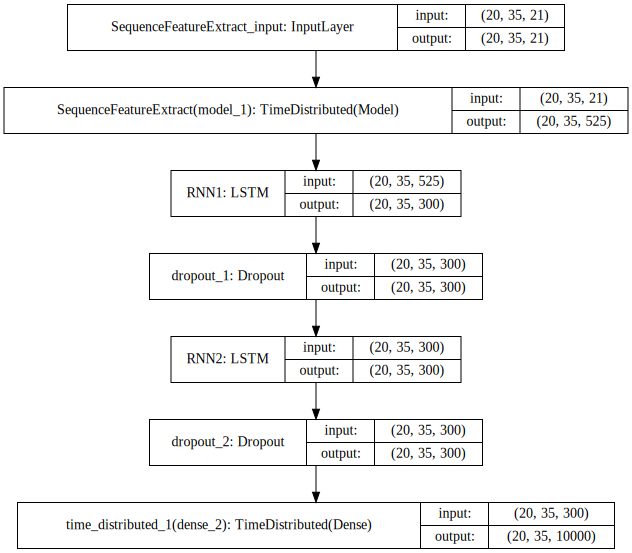

In [17]:
hidden_units = 300

CharRNN.add(
    layers.LSTM(
        hidden_units,
        return_sequences=True,
        name='RNN1'
    )
)

# Add a dropout of 0.5 to the input->hidden
CharRNN.add(
    layers.Dropout(0.5)
)

CharRNN.add(
    layers.LSTM(
        hidden_units,
        return_sequences=True,
        name='RNN2'
    )
)

# Add a dropout of 0.5 to thehidden->softmax
CharRNN.add(
    layers.Dropout(0.5)
)


CharRNN.add(
    layers.TimeDistributed(
        layers.Dense(
            len(word_idx), 
            activation='softmax'
        )
    )
)



CharRNN.summary()

# Block diagram
SVG(model_to_dot(CharRNN, show_shapes=True).create(prog='dot', format='svg'))

In the paper, SGD is used for training with an initial learning rate of 1.0 (which reduces in half if the loss does not improve after 1 epoch) and gradient clipping value of 5. First we need to define the loss $PPL$:

In [18]:
# Taken verbatim from icoxfog417 answer here:
# https://github.com/keras-team/keras/issues/2317
import keras.backend as K

def PPL(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

Then the optimizer for the model (norm clipping value of 5. is applied):

In [19]:
from keras.optimizers import SGD

opt = SGD(lr=1.0, clipnorm=5.)

Finally compile the model. It is also a good idea to save the untrained model.

In [20]:
CharRNN.compile(loss=PPL, metrics=['acc'], optimizer=opt)
CharRNN.save('char-rnn-cnn_untrained.hdf5')

We can now train the model. First we define several callbacks:

1. `ReduceLRPlateau` will half the learning rate if it does not improve after one epoch.
2. `ModelCheckpoint` (optional but recommended) will save a checkpoint of the model at each epoch.
3. `TensorBoard` (optional) will use Google's Tensorboard to show training progress.

Finally, we train the model using the `fit_generator` method with the generator objects defined above.

<b> Note: </b> You can observe training progress with tensorboard by running `tensorboard --logdir=logs` at the directory this notebook resides.

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from time import strftime

model_name = 'char-rnn-cnn'

# Define generators: train_gen for training, val_gen for validation (see above)
train_gen = generator(W_tr)
val_gen = generator(W_vd)

# Callbacks (see above.) comment out the ones you don't want to.
callbacks = [
    ReduceLROnPlateau(
        factor=0.5,                       # new LR = old LR * 0.5
        patience=1,                       # After one epoch
        min_lr=0.000976562,               # Minimum value of learning late
        monitor='val_loss',                   # Monitor loss 
        epsilon=1.                        # Amount by which a plateau is considered
    ),    
    ModelCheckpoint('checkpoints/{}_{{epoch:02d}}-{{val_loss:.2f}}.hdf5'.format(model_name)),
    TensorBoard(log_dir='logs/{}/{}'.format(
                    model_name,
                    strftime('%d-%m-%y/%H:%M:%S')
                    ),
                write_images=True,
               )
]

history = CharRNN.fit_generator(
    train_gen,
    epochs=25, #25 epochs for non-arabic languages (from the paper)
    steps_per_epoch=len(inputs_tr)//seq_len//batch_size, # number of batches to feed
    verbose=1,
    validation_data = val_gen,
    validation_steps = len(inputs_vd)//seq_len//batch_size,
    shuffle=False,
    callbacks=callbacks
)

/usr/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
1267/1267 [==============================] - 139s 110ms/step - loss: 250.4622 - acc: 0.0788 - val_loss: 209.9436 - val_acc: 0.1097
Epoch 2/25
1267/1267 [==============================] - 138s 109ms/step - loss: 188.5471 - acc: 0.1109 - val_loss: 190.8101 - val_acc: 0.1313
Epoch 3/25
1267/1267 [==============================] - 138s 109ms/step - loss: 162.1246 - acc: 0.1180 - val_loss: 186.4682 - val_acc: 0.1329
Epoch 4/25
1267/1267 [==============================] - 137s 109ms/step - loss: 147.7437 - acc: 0.1209 - val_loss: 185.8569 - val_acc: 0.1437
Epoch 5/25
1267/1267 [==============================] - 137s 108ms/step - loss: 139.9249 - acc: 0.1223 - val_loss: 190.4832 - val_acc: 0.1464
Epoch 6/25
1267/1267 [==============================] - 137s 108ms/step - loss: 128.5903 - acc: 0.1305 - val_loss: 194.4189 - val_acc: 0.1540
Epoch 7/25
1267/1267 [==============================] - 137s 108ms/step - loss: 122.5378 - acc: 0.1363 - val_loss: 192.9625 - val_acc: 0.1603
Epoch 

Finally we evaluate the model:

## Credits

* [Character-Aware Neural Language models, Kim, Y. et al.](https://arxiv.org/abs/1508.06615)
* [icoxfog417's answer about perplexity in Keras](https://github.com/keras-team/keras/issues/2317)
* [byung2685's implementation try](https://github.com/byung2685/Character-Aware-Neural-Language-Models)

## Final Word

Please note I wrote this tutorial in order for me to understand how to build such models. If you found it useful or have any questions, criticism, suggestions or other feedback, please [drop me an e-mail](mailto:e.t.chourdakis@qmul.ac.uk).

## Feedback

This area is for feedback I receive by e-mail.

In [ ]:
CharRNN.evaluate_generator(val_gen,len(inputs_vd)//seq_len//batch_size,)